In [1]:
import numpy as np
import cv2,os
import matplotlib.pyplot as plt

from scipy import interpolate
import torch

### Office Light

In [2]:
# office_light = np.array([1.40e-04,4.78e-04,1.45e-03,3.98e-03,4.27e-03,2.58e-03,1.62e-03,1.53e-03,
# 1.83e-03,2.19e-03,2.43e-03,2.54e-03,2.65e-03,2.71e-03,2.77e-03,2.81e-03,2.82e-03,2.77e-03,0.0026275,
# 0.00236847,0.00217062,0.00185621,0.00153536,0.00121575,0.000955384])


In [3]:
office_light = np.array([4.78e-04,3.98e-03,1.62e-03,1.83e-03,2.43e-03,2.71e-03,2.82e-03,0.0026275,
0.00217062,0.00121575,0.000955384])

### Bring Dataset

In [4]:
data_dir = "./crf_datas"
cam_H, cam_W = 580, 890
wvls = np.array([430, 450, 480, 500, 520, 550, 580, 600, 620, 650, 660])
size = 100

In [5]:
# wvl images
wvl_imgs = np.zeros(shape=(len(wvls), cam_H, cam_W, 3))

for w in range(len(wvls)):
    wvl_img = cv2.imread(os.path.join(data_dir, '%dnm/capture_0000.png'%wvls[w]))[:,:,::-1]/255.
    wvl_imgs[w] = wvl_img

In [6]:
center_points = np.array([290, 445])

### Visualization

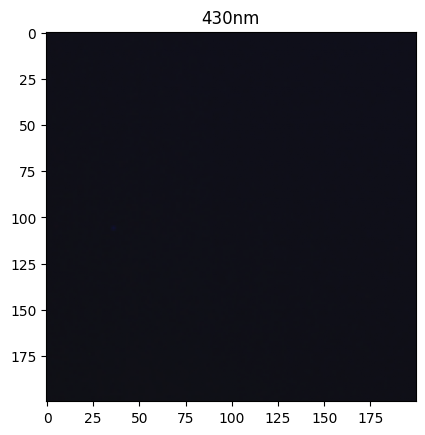

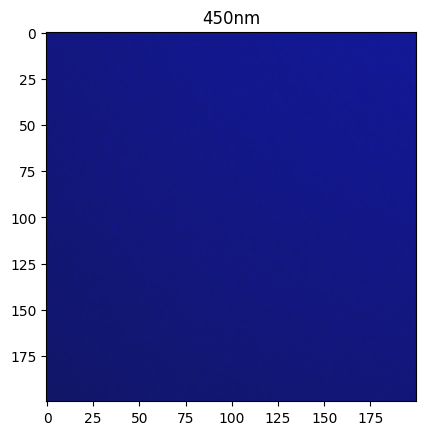

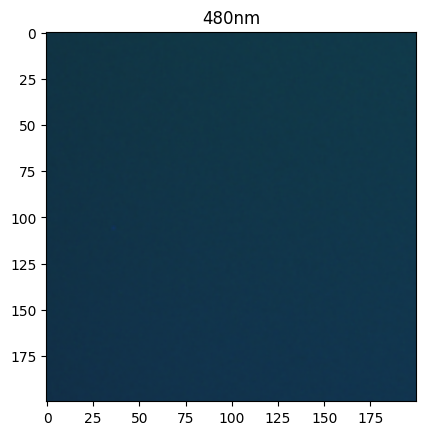

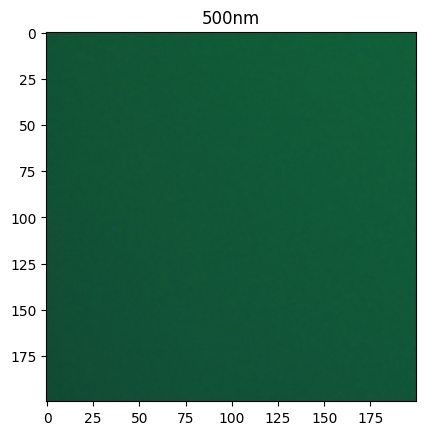

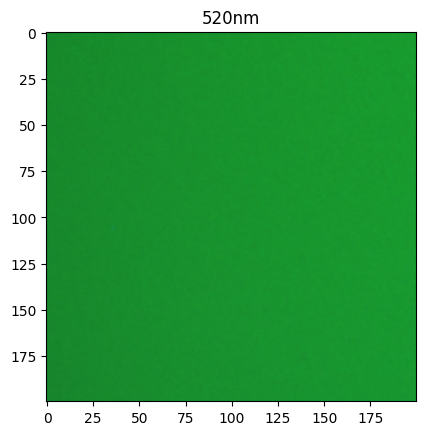

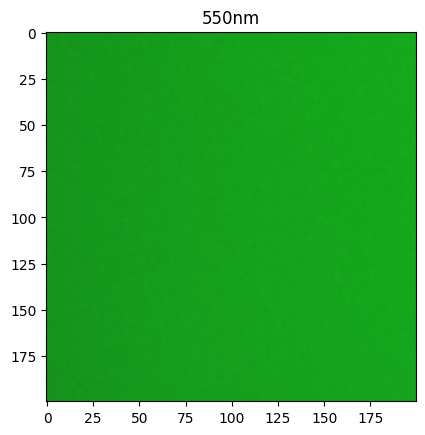

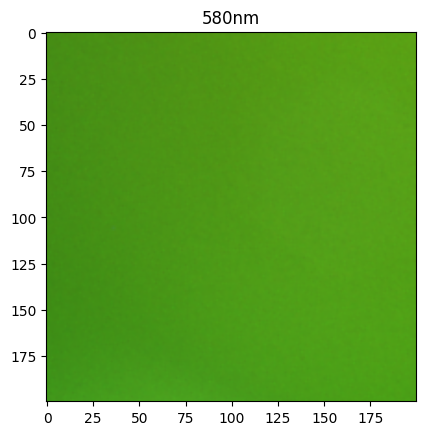

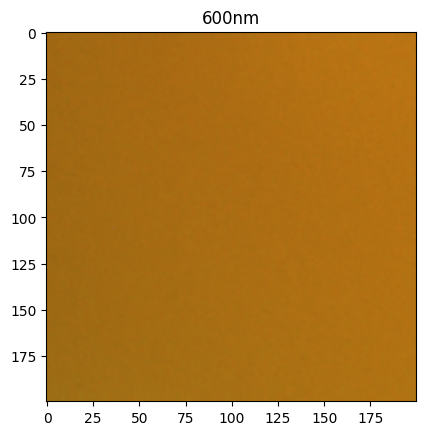

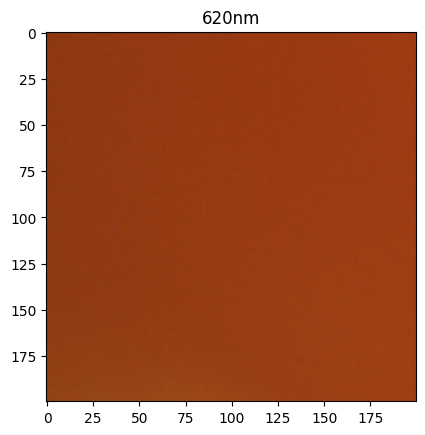

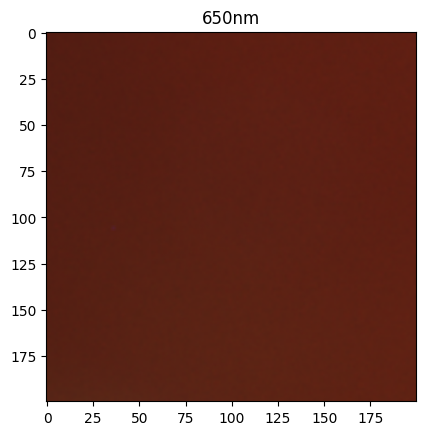

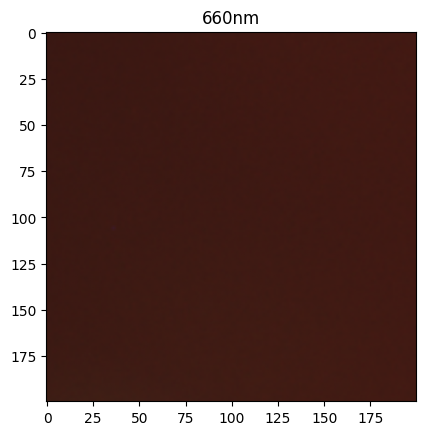

In [7]:
image_intensity = np.zeros(shape = (len(wvls), 3))

for w in range(len(wvls)):
    plt.figure()
    wvl_intensity_zero = wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size].reshape(-1, 3).mean(axis = 0)
    plt.imshow(wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size]), plt.title("%dnm"%wvls[w])

### Image intensity

In [8]:
wvls_intensity = np.zeros(shape = (len(wvls), 3))

for w in range(len(wvls)):
    wvl_intensity = wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size].reshape(-1, 3).mean(axis = 0)

    wvls_intensity[w] = wvl_intensity
    

In [9]:
I_RGB = wvls_intensity * 255.

### CRF interpolation

In [10]:
CRF = np.zeros(shape=(len(wvls), 3))

for c in range(3):
    for w in range(len(wvls)): 
        CRF[w,c] = I_RGB[w,c] / (office_light[w])

### Interpolation

In [11]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

In [12]:
wvls = torch.tensor([430, 450, 480, 500, 520, 550, 580, 600, 620, 650, 660])*1e-9
new_wvls = torch.linspace(420*1e-9, 660*1e-9, 25) # 400 ~ 680 까지 10nm 간격으로

CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 3)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 3)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 3)

In [13]:
CRF = np.stack((CRF_R, CRF_G, CRF_B))
CRF[:,0] = CRF[:,1] - 10000

In [20]:
from scipy.interpolate import interp1d
map_scale = interp1d([CRF.min(), CRF.max()], [0.1, 1.])
CRF = torch.tensor(map_scale(CRF).astype(np.float32))

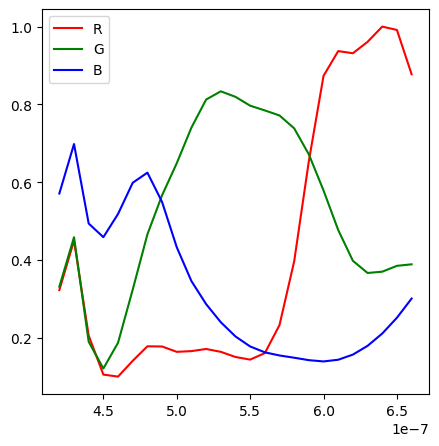

In [21]:
plt.figure(figsize=(5,5))
plt.plot(new_wvls, CRF[0], label = 'R',  c='red')
plt.plot(new_wvls, CRF[1], label = 'G', c='green')
plt.plot(new_wvls, CRF[2], label = 'B', c='blue')
plt.legend()

In [22]:
np.save('CRF.npy', CRF)